This project was heavily inspired by this paper:  https://www.lamsade.dauphine.fr/~cazenave/papers/ImprovingModelAndSearchForComputerGo.pdf

In [3]:
!pip install tensorflow

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import gc

import golois

2023-07-30 14:58:28.346090: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-30 14:58:28.976942: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 14:58:30.601055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from tensorflow.keras.layers import AvgPool2D, MaxPool2D, GlobalAveragePooling2D, Reshape,ZeroPadding2D,GlobalAveragePooling2D

In [6]:
!pip3 install pybind11

In [7]:
!c++ -O3 -Wall -shared -std=c++11 -fsized-deallocation -fPIC `python3.9 -m pybind11 --includes` golois.cpp -o golois$(python3.9-config --extension-suffix)

In file included from golois.cpp:17:
Board.h: In member function ‘bool Board::isCapturedLadder(int, int, Rzone*)’:
Board.h:1767:15: warning: unused variable ‘n1’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-variable-Wunused-variable]8;;]
 1767 |           int n1 = nbLiberties (inter, liberties1, stones1, 3);
      |               ^~
Board.h:1788:19: warning: unused variable ‘n1’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-variable-Wunused-variable]8;;]
 1788 |               int n1 = nbLiberties (inter, liberties1, stones1, 3);
      |                   ^~
Board.h: In member function ‘void Board::computeLadders(int)’:
Board.h:1819:9: warning: unused variable ‘other’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-variable-Wunused-variable]8;;]
 1819 |     int other = opponent (color);
      |         ^~~~~
Board.h: In member function ‘void Board::computeAllLadders(int, bool)’:
Board.h:206

In [8]:
planes = 31
moves = 361
N = 20000
epochs = 200
batch = 100
filters = 48

input_data = np.random.randint(2, size=(N, 19, 19, planes))
input_data = input_data.astype ('float32')

policy = np.random.randint(moves, size=(N,))
policy = keras.utils.to_categorical (policy)

value = np.random.randint(2, size=(N,))
value = value.astype ('float32')

end = np.random.randint(2, size=(N, 19, 19, 2))
end = end.astype ('float32')

groups = np.zeros((N, 19, 19, 1))
groups = groups.astype ('float32')

print ("getValidation", flush = True)
golois.getValidation (input_data, policy, value, end)


getValidation


r.shape = (20000, 19, 19, 31)
nbExamples = 20000
nbPositionsSGF = 29425326
nbPositionsSGF = 29425326
loading validation.data


Inverted residual block:

In [21]:
def SE_block(t,filters,ratio=filters):
    se_shape = (1,1,filters)
    se = GlobalAveragePooling2D()(t)
    se = Reshape(se_shape)(se)
    se = layers.Dense(filters//ratio,activation='relu', use_bias = False)(se)
    se = layers.Dense(filters, activation='sigmoid', use_bias = False)(se)
    x = layers.Multiply()([t,se])
    return x


In [22]:
def bottleneck_block(x, expand=96, squeeze=filters):
    m = layers.Conv2D(expand, (1,1), kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(x)
    m = layers.BatchNormalization()(m)
    m = layers.Activation('relu')(m)
    m = layers.DepthwiseConv2D((3,3), padding='same', kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(m)
    m = layers.BatchNormalization()(m)
    m = layers.Activation('relu')(m)
    m = layers.Conv2D(squeeze, (1,1), kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(m)
    m = layers.BatchNormalization()(m)
    m = SE_block(m,filters)
    return layers.Add()([m, x])

In [11]:


input = keras.Input(shape=(19, 19, planes), name='board')
x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input)
for i in range (5):
    #x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = bottleneck_block(x)
policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation('softmax', name='policy')(policy_head)

value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
value_head = layers.Flatten()(value_head)
value_head = layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

model = keras.Model(inputs=input, outputs=[policy_head, value_head])

model.summary ()


2023-07-30 14:59:09.464214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 14:59:09.693872: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 board (InputLayer)          [(None, 19, 19, 31)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 19, 19, 48)           1536      ['board[0][0]']               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 19, 19, 96)           4608      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 19, 19, 96)           384       ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [12]:
def scheduler(epoch, lr):
    if epoch < 100 or epoch % 50 !=0:
        return lr
    else:
        return lr*0.1

In [13]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
optimizer = keras.optimizers.SGD(lr=0.0005, momentum=0.9)

model.compile(optimizer=optimizer,
              loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
              loss_weights={'policy' : 1.0, 'value' : 1.0},
              metrics={'policy': 'categorical_accuracy', 'value': 'mse'})

for i in range (1, epochs + 1):
    print ('epoch ' + str (i))
    golois.getBatch (input_data, policy, value, end, groups, i * N)
    history = model.fit(input_data,
                        {'policy': policy, 'value': value},
                        epochs=1, batch_size=batch, callbacks=[callback])
    if (i % 5 == 0):
        gc.collect ()
    if (i % 20 == 0):
        golois.getValidation (input_data, policy, value, end)
        val = model.evaluate (input_data,
                              [policy, value], verbose = 0, batch_size=batch)
        print ("val =", val)
        model.save ('arij.h5')


epoch 1


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 47s 218ms/step - loss: 4.6819 - policy_loss: 3.9083 - value_loss: 0.7001 - policy_categorical_accuracy: 0.1807 - value_mse: 0.1235 - lr: 0.0100
epoch 2


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.9828 - policy_loss: 3.2155 - value_loss: 0.6935 - policy_categorical_accuracy: 0.2715 - value_mse: 0.1200 - lr: 0.0100
epoch 3


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.8571 - policy_loss: 3.0902 - value_loss: 0.6930 - policy_categorical_accuracy: 0.2920 - value_mse: 0.1187 - lr: 0.0100
epoch 4


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.7573 - policy_loss: 2.9903 - value_loss: 0.6931 - policy_categorical_accuracy: 0.3058 - value_mse: 0.1194 - lr: 0.0100
epoch 5


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.6985 - policy_loss: 2.9316 - value_loss: 0.6930 - policy_categorical_accuracy: 0.3113 - value_mse: 0.1204 - lr: 0.0100
epoch 6


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.6451 - policy_loss: 2.8785 - value_loss: 0.6927 - policy_categorical_accuracy: 0.3225 - value_mse: 0.1197 - lr: 0.0100
epoch 7


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.6328 - policy_loss: 2.8661 - value_loss: 0.6929 - policy_categorical_accuracy: 0.3234 - value_mse: 0.1197 - lr: 0.0100
epoch 8


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.6047 - policy_loss: 2.8382 - value_loss: 0.6928 - policy_categorical_accuracy: 0.3271 - value_mse: 0.1186 - lr: 0.0100
epoch 9


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 218ms/step - loss: 3.5796 - policy_loss: 2.8129 - value_loss: 0.6931 - policy_categorical_accuracy: 0.3307 - value_mse: 0.1190 - lr: 0.0100
epoch 10


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.5274 - policy_loss: 2.7611 - value_loss: 0.6927 - policy_categorical_accuracy: 0.3410 - value_mse: 0.1197 - lr: 0.0100
epoch 11


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.5325 - policy_loss: 2.7661 - value_loss: 0.6930 - policy_categorical_accuracy: 0.3372 - value_mse: 0.1206 - lr: 0.0100
epoch 12


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.5414 - policy_loss: 2.7751 - value_loss: 0.6930 - policy_categorical_accuracy: 0.3422 - value_mse: 0.1199 - lr: 0.0100
epoch 13


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 219ms/step - loss: 3.5189 - policy_loss: 2.7525 - value_loss: 0.6931 - policy_categorical_accuracy: 0.3410 - value_mse: 0.1196 - lr: 0.0100
epoch 14


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.4860 - policy_loss: 2.7197 - value_loss: 0.6932 - policy_categorical_accuracy: 0.3500 - value_mse: 0.1191 - lr: 0.0100
epoch 15


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.4627 - policy_loss: 2.6966 - value_loss: 0.6930 - policy_categorical_accuracy: 0.3456 - value_mse: 0.1192 - lr: 0.0100
epoch 16


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.4751 - policy_loss: 2.7093 - value_loss: 0.6929 - policy_categorical_accuracy: 0.3524 - value_mse: 0.1190 - lr: 0.0100
epoch 17


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.4533 - policy_loss: 2.6880 - value_loss: 0.6926 - policy_categorical_accuracy: 0.3542 - value_mse: 0.1189 - lr: 0.0100
epoch 18


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.4492 - policy_loss: 2.6836 - value_loss: 0.6929 - policy_categorical_accuracy: 0.3561 - value_mse: 0.1208 - lr: 0.0100
epoch 19


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.4813 - policy_loss: 2.7159 - value_loss: 0.6929 - policy_categorical_accuracy: 0.3462 - value_mse: 0.1200 - lr: 0.0100
epoch 20


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.4453 - policy_loss: 2.6799 - value_loss: 0.6929 - policy_categorical_accuracy: 0.3541 - value_mse: 0.1185 - lr: 0.0100


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.430845260620117, 2.6654880046844482, 0.6929406523704529, 0.35225000977516174, 0.11965394020080566]
epoch 21


/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.4240 - policy_loss: 2.6587 - value_loss: 0.6929 - policy_categorical_accuracy: 0.3514 - value_mse: 0.1206 - lr: 0.0100
epoch 22


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.4198 - policy_loss: 2.6547 - value_loss: 0.6928 - policy_categorical_accuracy: 0.3513 - value_mse: 0.1198 - lr: 0.0100
epoch 23


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.4123 - policy_loss: 2.6473 - value_loss: 0.6928 - policy_categorical_accuracy: 0.3575 - value_mse: 0.1202 - lr: 0.0100
epoch 24


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.4244 - policy_loss: 2.6593 - value_loss: 0.6931 - policy_categorical_accuracy: 0.3514 - value_mse: 0.1202 - lr: 0.0100
epoch 25


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.3947 - policy_loss: 2.6298 - value_loss: 0.6930 - policy_categorical_accuracy: 0.3584 - value_mse: 0.1203 - lr: 0.0100
epoch 26


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.4150 - policy_loss: 2.6501 - value_loss: 0.6931 - policy_categorical_accuracy: 0.3568 - value_mse: 0.1191 - lr: 0.0100
epoch 27


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.4132 - policy_loss: 2.6486 - value_loss: 0.6930 - policy_categorical_accuracy: 0.3557 - value_mse: 0.1192 - lr: 0.0100
epoch 28


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.3764 - policy_loss: 2.6120 - value_loss: 0.6927 - policy_categorical_accuracy: 0.3620 - value_mse: 0.1207 - lr: 0.0100
epoch 29


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 227ms/step - loss: 3.3796 - policy_loss: 2.6152 - value_loss: 0.6929 - policy_categorical_accuracy: 0.3623 - value_mse: 0.1198 - lr: 0.0100
epoch 30


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.3864 - policy_loss: 2.6222 - value_loss: 0.6929 - policy_categorical_accuracy: 0.3573 - value_mse: 0.1193 - lr: 0.0100
epoch 31


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.3813 - policy_loss: 2.6171 - value_loss: 0.6929 - policy_categorical_accuracy: 0.3584 - value_mse: 0.1194 - lr: 0.0100
epoch 32


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.3852 - policy_loss: 2.6211 - value_loss: 0.6929 - policy_categorical_accuracy: 0.3595 - value_mse: 0.1209 - lr: 0.0100
epoch 33


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.3576 - policy_loss: 2.5937 - value_loss: 0.6928 - policy_categorical_accuracy: 0.3656 - value_mse: 0.1188 - lr: 0.0100
epoch 34


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.3531 - policy_loss: 2.5893 - value_loss: 0.6927 - policy_categorical_accuracy: 0.3607 - value_mse: 0.1211 - lr: 0.0100
epoch 35


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.3777 - policy_loss: 2.6142 - value_loss: 0.6926 - policy_categorical_accuracy: 0.3606 - value_mse: 0.1197 - lr: 0.0100
epoch 36


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.3617 - policy_loss: 2.5984 - value_loss: 0.6925 - policy_categorical_accuracy: 0.3634 - value_mse: 0.1193 - lr: 0.0100
epoch 37


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.3351 - policy_loss: 2.5722 - value_loss: 0.6922 - policy_categorical_accuracy: 0.3656 - value_mse: 0.1187 - lr: 0.0100
epoch 38


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.3506 - policy_loss: 2.5880 - value_loss: 0.6920 - policy_categorical_accuracy: 0.3658 - value_mse: 0.1177 - lr: 0.0100
epoch 39


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.3399 - policy_loss: 2.5781 - value_loss: 0.6913 - policy_categorical_accuracy: 0.3645 - value_mse: 0.1191 - lr: 0.0100
epoch 40


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.3299 - policy_loss: 2.5686 - value_loss: 0.6908 - policy_categorical_accuracy: 0.3670 - value_mse: 0.1178 - lr: 0.0100


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.364349126815796, 2.6039066314697266, 0.6900443434715271, 0.36125001311302185, 0.11820860952138901]
epoch 41


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.3453 - policy_loss: 2.5852 - value_loss: 0.6898 - policy_categorical_accuracy: 0.3620 - value_mse: 0.1173 - lr: 0.0100
epoch 42


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.3270 - policy_loss: 2.5670 - value_loss: 0.6898 - policy_categorical_accuracy: 0.3686 - value_mse: 0.1172 - lr: 0.0100
epoch 43


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.3234 - policy_loss: 2.5643 - value_loss: 0.6889 - policy_categorical_accuracy: 0.3681 - value_mse: 0.1172 - lr: 0.0100
epoch 44


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.3074 - policy_loss: 2.5494 - value_loss: 0.6880 - policy_categorical_accuracy: 0.3666 - value_mse: 0.1177 - lr: 0.0100
epoch 45


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.3151 - policy_loss: 2.5573 - value_loss: 0.6879 - policy_categorical_accuracy: 0.3692 - value_mse: 0.1181 - lr: 0.0100
epoch 46


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.3270 - policy_loss: 2.5686 - value_loss: 0.6885 - policy_categorical_accuracy: 0.3659 - value_mse: 0.1174 - lr: 0.0100
epoch 47


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.3126 - policy_loss: 2.5554 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3636 - value_mse: 0.1173 - lr: 0.0100
epoch 48


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.3022 - policy_loss: 2.5446 - value_loss: 0.6879 - policy_categorical_accuracy: 0.3688 - value_mse: 0.1176 - lr: 0.0100
epoch 49


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.3070 - policy_loss: 2.5490 - value_loss: 0.6883 - policy_categorical_accuracy: 0.3708 - value_mse: 0.1179 - lr: 0.0100
epoch 50


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 218ms/step - loss: 3.3119 - policy_loss: 2.5545 - value_loss: 0.6878 - policy_categorical_accuracy: 0.3668 - value_mse: 0.1173 - lr: 0.0100
epoch 51


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 218ms/step - loss: 3.2889 - policy_loss: 2.5310 - value_loss: 0.6884 - policy_categorical_accuracy: 0.3734 - value_mse: 0.1173 - lr: 0.0100
epoch 52


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.2924 - policy_loss: 2.5348 - value_loss: 0.6882 - policy_categorical_accuracy: 0.3664 - value_mse: 0.1164 - lr: 0.0100
epoch 53


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.2891 - policy_loss: 2.5329 - value_loss: 0.6869 - policy_categorical_accuracy: 0.3683 - value_mse: 0.1171 - lr: 0.0100
epoch 54


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.2813 - policy_loss: 2.5241 - value_loss: 0.6880 - policy_categorical_accuracy: 0.3745 - value_mse: 0.1180 - lr: 0.0100
epoch 55


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 219ms/step - loss: 3.2778 - policy_loss: 2.5202 - value_loss: 0.6884 - policy_categorical_accuracy: 0.3735 - value_mse: 0.1159 - lr: 0.0100
epoch 56


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.2785 - policy_loss: 2.5212 - value_loss: 0.6883 - policy_categorical_accuracy: 0.3692 - value_mse: 0.1173 - lr: 0.0100
epoch 57


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.2763 - policy_loss: 2.5191 - value_loss: 0.6882 - policy_categorical_accuracy: 0.3753 - value_mse: 0.1169 - lr: 0.0100
epoch 58


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.2555 - policy_loss: 2.4994 - value_loss: 0.6872 - policy_categorical_accuracy: 0.3783 - value_mse: 0.1180 - lr: 0.0100
epoch 59


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.2629 - policy_loss: 2.5060 - value_loss: 0.6881 - policy_categorical_accuracy: 0.3740 - value_mse: 0.1153 - lr: 0.0100
epoch 60


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.2759 - policy_loss: 2.5196 - value_loss: 0.6876 - policy_categorical_accuracy: 0.3758 - value_mse: 0.1162 - lr: 0.0100


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.2781741619110107, 2.5225603580474854, 0.6868959665298462, 0.3735499978065491, 0.11664533615112305]
epoch 61


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.2652 - policy_loss: 2.5095 - value_loss: 0.6870 - policy_categorical_accuracy: 0.3708 - value_mse: 0.1163 - lr: 0.0100
epoch 62


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.2626 - policy_loss: 2.5069 - value_loss: 0.6871 - policy_categorical_accuracy: 0.3770 - value_mse: 0.1173 - lr: 0.0100
epoch 63


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.2499 - policy_loss: 2.4934 - value_loss: 0.6880 - policy_categorical_accuracy: 0.3799 - value_mse: 0.1163 - lr: 0.0100
epoch 64


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.2489 - policy_loss: 2.4930 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3767 - value_mse: 0.1169 - lr: 0.0100
epoch 65


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.2323 - policy_loss: 2.4774 - value_loss: 0.6865 - policy_categorical_accuracy: 0.3785 - value_mse: 0.1172 - lr: 0.0100
epoch 66


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 219ms/step - loss: 3.2482 - policy_loss: 2.4923 - value_loss: 0.6876 - policy_categorical_accuracy: 0.3799 - value_mse: 0.1173 - lr: 0.0100
epoch 67


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.2452 - policy_loss: 2.4896 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3717 - value_mse: 0.1155 - lr: 0.0100
epoch 68


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.2286 - policy_loss: 2.4729 - value_loss: 0.6875 - policy_categorical_accuracy: 0.3806 - value_mse: 0.1159 - lr: 0.0100
epoch 69


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.2479 - policy_loss: 2.4935 - value_loss: 0.6863 - policy_categorical_accuracy: 0.3771 - value_mse: 0.1153 - lr: 0.0100
epoch 70


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.2359 - policy_loss: 2.4806 - value_loss: 0.6873 - policy_categorical_accuracy: 0.3783 - value_mse: 0.1174 - lr: 0.0100
epoch 71


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.2408 - policy_loss: 2.4846 - value_loss: 0.6883 - policy_categorical_accuracy: 0.3753 - value_mse: 0.1175 - lr: 0.0100
epoch 72


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.2312 - policy_loss: 2.4759 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3814 - value_mse: 0.1170 - lr: 0.0100
epoch 73


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 227ms/step - loss: 3.2356 - policy_loss: 2.4805 - value_loss: 0.6873 - policy_categorical_accuracy: 0.3823 - value_mse: 0.1172 - lr: 0.0100
epoch 74


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.2270 - policy_loss: 2.4712 - value_loss: 0.6880 - policy_categorical_accuracy: 0.3811 - value_mse: 0.1160 - lr: 0.0100
epoch 75


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.2467 - policy_loss: 2.4920 - value_loss: 0.6869 - policy_categorical_accuracy: 0.3812 - value_mse: 0.1175 - lr: 0.0100
epoch 76


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.2380 - policy_loss: 2.4832 - value_loss: 0.6870 - policy_categorical_accuracy: 0.3749 - value_mse: 0.1167 - lr: 0.0100
epoch 77


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.2086 - policy_loss: 2.4530 - value_loss: 0.6880 - policy_categorical_accuracy: 0.3855 - value_mse: 0.1186 - lr: 0.0100
epoch 78


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.2143 - policy_loss: 2.4596 - value_loss: 0.6871 - policy_categorical_accuracy: 0.3823 - value_mse: 0.1164 - lr: 0.0100
epoch 79


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 219ms/step - loss: 3.2199 - policy_loss: 2.4648 - value_loss: 0.6876 - policy_categorical_accuracy: 0.3806 - value_mse: 0.1174 - lr: 0.0100
epoch 80


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 219ms/step - loss: 3.2275 - policy_loss: 2.4725 - value_loss: 0.6875 - policy_categorical_accuracy: 0.3875 - value_mse: 0.1167 - lr: 0.0100


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.2421059608459473, 2.487244129180908, 0.6873760223388672, 0.3779999911785126, 0.116875559091568]
epoch 81


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.2029 - policy_loss: 2.4481 - value_loss: 0.6873 - policy_categorical_accuracy: 0.3882 - value_mse: 0.1177 - lr: 0.0100
epoch 82


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.2204 - policy_loss: 2.4655 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3799 - value_mse: 0.1176 - lr: 0.0100
epoch 83


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1826 - policy_loss: 2.4284 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3873 - value_mse: 0.1168 - lr: 0.0100
epoch 84


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1997 - policy_loss: 2.4453 - value_loss: 0.6871 - policy_categorical_accuracy: 0.3898 - value_mse: 0.1159 - lr: 0.0100
epoch 85


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.2262 - policy_loss: 2.4710 - value_loss: 0.6880 - policy_categorical_accuracy: 0.3778 - value_mse: 0.1157 - lr: 0.0100
epoch 86


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.1907 - policy_loss: 2.4369 - value_loss: 0.6866 - policy_categorical_accuracy: 0.3869 - value_mse: 0.1173 - lr: 0.0100
epoch 87


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.1819 - policy_loss: 2.4279 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3863 - value_mse: 0.1174 - lr: 0.0100
epoch 88


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.2055 - policy_loss: 2.4523 - value_loss: 0.6862 - policy_categorical_accuracy: 0.3866 - value_mse: 0.1158 - lr: 0.0100
epoch 89


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 219ms/step - loss: 3.2250 - policy_loss: 2.4704 - value_loss: 0.6876 - policy_categorical_accuracy: 0.3808 - value_mse: 0.1171 - lr: 0.0100
epoch 90


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.1820 - policy_loss: 2.4270 - value_loss: 0.6880 - policy_categorical_accuracy: 0.3881 - value_mse: 0.1168 - lr: 0.0100
epoch 91


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.2004 - policy_loss: 2.4462 - value_loss: 0.6872 - policy_categorical_accuracy: 0.3840 - value_mse: 0.1176 - lr: 0.0100
epoch 92


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.2031 - policy_loss: 2.4496 - value_loss: 0.6866 - policy_categorical_accuracy: 0.3834 - value_mse: 0.1169 - lr: 0.0100
epoch 93


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.1912 - policy_loss: 2.4378 - value_loss: 0.6865 - policy_categorical_accuracy: 0.3825 - value_mse: 0.1177 - lr: 0.0100
epoch 94


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 219ms/step - loss: 3.1850 - policy_loss: 2.4313 - value_loss: 0.6869 - policy_categorical_accuracy: 0.3834 - value_mse: 0.1167 - lr: 0.0100
epoch 95


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1732 - policy_loss: 2.4201 - value_loss: 0.6863 - policy_categorical_accuracy: 0.3871 - value_mse: 0.1175 - lr: 0.0100
epoch 96


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 219ms/step - loss: 3.1641 - policy_loss: 2.4105 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3896 - value_mse: 0.1164 - lr: 0.0100
epoch 97


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.1939 - policy_loss: 2.4406 - value_loss: 0.6866 - policy_categorical_accuracy: 0.3821 - value_mse: 0.1169 - lr: 0.0100
epoch 98


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.1822 - policy_loss: 2.4287 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3881 - value_mse: 0.1171 - lr: 0.0100
epoch 99


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1855 - policy_loss: 2.4329 - value_loss: 0.6860 - policy_categorical_accuracy: 0.3837 - value_mse: 0.1166 - lr: 0.0100
epoch 100


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 219ms/step - loss: 3.1880 - policy_loss: 2.4340 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3801 - value_mse: 0.1156 - lr: 0.0100


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.1824347972869873, 2.4277312755584717, 0.6881232857704163, 0.3887999951839447, 0.11725801974534988]
epoch 101


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.1758 - policy_loss: 2.4228 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3898 - value_mse: 0.1174 - lr: 0.0100
learning rate is: 0.01
epoch 102


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.1705 - policy_loss: 2.4176 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3913 - value_mse: 0.1160 - lr: 0.0100
epoch 103


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1761 - policy_loss: 2.4223 - value_loss: 0.6873 - policy_categorical_accuracy: 0.3860 - value_mse: 0.1163 - lr: 0.0100
epoch 104


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1640 - policy_loss: 2.4105 - value_loss: 0.6870 - policy_categorical_accuracy: 0.3884 - value_mse: 0.1170 - lr: 0.0100
epoch 105


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 219ms/step - loss: 3.1702 - policy_loss: 2.4159 - value_loss: 0.6878 - policy_categorical_accuracy: 0.3891 - value_mse: 0.1174 - lr: 0.0100
epoch 106


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.1547 - policy_loss: 2.4004 - value_loss: 0.6879 - policy_categorical_accuracy: 0.3926 - value_mse: 0.1177 - lr: 0.0100
epoch 107


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.1613 - policy_loss: 2.4089 - value_loss: 0.6860 - policy_categorical_accuracy: 0.3925 - value_mse: 0.1162 - lr: 0.0100
epoch 108


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.1688 - policy_loss: 2.4151 - value_loss: 0.6873 - policy_categorical_accuracy: 0.3880 - value_mse: 0.1168 - lr: 0.0100
epoch 109


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 219ms/step - loss: 3.1763 - policy_loss: 2.4228 - value_loss: 0.6872 - policy_categorical_accuracy: 0.3843 - value_mse: 0.1165 - lr: 0.0100
epoch 110


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.1535 - policy_loss: 2.4007 - value_loss: 0.6866 - policy_categorical_accuracy: 0.3865 - value_mse: 0.1172 - lr: 0.0100
epoch 111


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.1739 - policy_loss: 2.4207 - value_loss: 0.6870 - policy_categorical_accuracy: 0.3893 - value_mse: 0.1159 - lr: 0.0100
epoch 112


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.1351 - policy_loss: 2.3821 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3931 - value_mse: 0.1165 - lr: 0.0100
epoch 113


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1551 - policy_loss: 2.4017 - value_loss: 0.6872 - policy_categorical_accuracy: 0.3857 - value_mse: 0.1184 - lr: 0.0100
epoch 114


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.1819 - policy_loss: 2.4289 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3857 - value_mse: 0.1159 - lr: 0.0100
epoch 115


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 226ms/step - loss: 3.1435 - policy_loss: 2.3903 - value_loss: 0.6871 - policy_categorical_accuracy: 0.3879 - value_mse: 0.1154 - lr: 0.0100
epoch 116


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1739 - policy_loss: 2.4207 - value_loss: 0.6870 - policy_categorical_accuracy: 0.3884 - value_mse: 0.1157 - lr: 0.0100
epoch 117


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.1608 - policy_loss: 2.4081 - value_loss: 0.6866 - policy_categorical_accuracy: 0.3914 - value_mse: 0.1162 - lr: 0.0100
epoch 118


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.1574 - policy_loss: 2.4040 - value_loss: 0.6873 - policy_categorical_accuracy: 0.3911 - value_mse: 0.1162 - lr: 0.0100
epoch 119


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1380 - policy_loss: 2.3843 - value_loss: 0.6876 - policy_categorical_accuracy: 0.3950 - value_mse: 0.1171 - lr: 0.0100
epoch 120


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 226ms/step - loss: 3.1536 - policy_loss: 2.4018 - value_loss: 0.6858 - policy_categorical_accuracy: 0.3899 - value_mse: 0.1150 - lr: 0.0100


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.166341543197632, 2.413846015930176, 0.6864297986030579, 0.3922500014305115, 0.11641830950975418]
epoch 121


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1485 - policy_loss: 2.3953 - value_loss: 0.6871 - policy_categorical_accuracy: 0.3875 - value_mse: 0.1167 - lr: 0.0100
epoch 122


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.1511 - policy_loss: 2.3986 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3945 - value_mse: 0.1164 - lr: 0.0100
epoch 123


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.1665 - policy_loss: 2.4136 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3910 - value_mse: 0.1168 - lr: 0.0100
epoch 124


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.1341 - policy_loss: 2.3811 - value_loss: 0.6870 - policy_categorical_accuracy: 0.3952 - value_mse: 0.1168 - lr: 0.0100
epoch 125


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1442 - policy_loss: 2.3918 - value_loss: 0.6863 - policy_categorical_accuracy: 0.3916 - value_mse: 0.1155 - lr: 0.0100
epoch 126


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1350 - policy_loss: 2.3831 - value_loss: 0.6859 - policy_categorical_accuracy: 0.3933 - value_mse: 0.1156 - lr: 0.0100
epoch 127


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1556 - policy_loss: 2.4031 - value_loss: 0.6866 - policy_categorical_accuracy: 0.3896 - value_mse: 0.1163 - lr: 0.0100
epoch 128


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1337 - policy_loss: 2.3804 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3886 - value_mse: 0.1174 - lr: 0.0100
epoch 129


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 227ms/step - loss: 3.1462 - policy_loss: 2.3929 - value_loss: 0.6875 - policy_categorical_accuracy: 0.3906 - value_mse: 0.1159 - lr: 0.0100
epoch 130


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.1460 - policy_loss: 2.3937 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3939 - value_mse: 0.1173 - lr: 0.0100
epoch 131


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.1378 - policy_loss: 2.3846 - value_loss: 0.6873 - policy_categorical_accuracy: 0.3898 - value_mse: 0.1162 - lr: 0.0100
epoch 132


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1339 - policy_loss: 2.3801 - value_loss: 0.6879 - policy_categorical_accuracy: 0.3953 - value_mse: 0.1161 - lr: 0.0100
epoch 133


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1178 - policy_loss: 2.3651 - value_loss: 0.6869 - policy_categorical_accuracy: 0.3965 - value_mse: 0.1168 - lr: 0.0100
epoch 134


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1148 - policy_loss: 2.3617 - value_loss: 0.6873 - policy_categorical_accuracy: 0.3954 - value_mse: 0.1154 - lr: 0.0100
epoch 135


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.1221 - policy_loss: 2.3691 - value_loss: 0.6871 - policy_categorical_accuracy: 0.3984 - value_mse: 0.1154 - lr: 0.0100
epoch 136


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1370 - policy_loss: 2.3842 - value_loss: 0.6870 - policy_categorical_accuracy: 0.3916 - value_mse: 0.1156 - lr: 0.0100
epoch 137


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.1290 - policy_loss: 2.3765 - value_loss: 0.6867 - policy_categorical_accuracy: 0.3922 - value_mse: 0.1171 - lr: 0.0100
epoch 138


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1372 - policy_loss: 2.3842 - value_loss: 0.6872 - policy_categorical_accuracy: 0.3910 - value_mse: 0.1165 - lr: 0.0100
epoch 139


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1378 - policy_loss: 2.3855 - value_loss: 0.6865 - policy_categorical_accuracy: 0.3929 - value_mse: 0.1157 - lr: 0.0100
epoch 140


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.1038 - policy_loss: 2.3513 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3980 - value_mse: 0.1170 - lr: 0.0100


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.1354401111602783, 2.382704973220825, 0.6869840621948242, 0.395550012588501, 0.11668964475393295]
epoch 141


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1348 - policy_loss: 2.3826 - value_loss: 0.6865 - policy_categorical_accuracy: 0.3936 - value_mse: 0.1164 - lr: 0.0100
epoch 142


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1398 - policy_loss: 2.3873 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3963 - value_mse: 0.1171 - lr: 0.0100
epoch 143


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.0940 - policy_loss: 2.3409 - value_loss: 0.6873 - policy_categorical_accuracy: 0.4031 - value_mse: 0.1164 - lr: 0.0100
epoch 144


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.1348 - policy_loss: 2.3827 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3931 - value_mse: 0.1149 - lr: 0.0100
epoch 145


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1301 - policy_loss: 2.3776 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3975 - value_mse: 0.1165 - lr: 0.0100
epoch 146


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 220ms/step - loss: 3.1326 - policy_loss: 2.3801 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3893 - value_mse: 0.1168 - lr: 0.0100
epoch 147


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.1043 - policy_loss: 2.3516 - value_loss: 0.6869 - policy_categorical_accuracy: 0.3979 - value_mse: 0.1160 - lr: 0.0100
epoch 148


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1337 - policy_loss: 2.3813 - value_loss: 0.6867 - policy_categorical_accuracy: 0.3895 - value_mse: 0.1161 - lr: 0.0100
epoch 149


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1037 - policy_loss: 2.3511 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3983 - value_mse: 0.1172 - lr: 0.0100
epoch 150


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.1277 - policy_loss: 2.3762 - value_loss: 0.6857 - policy_categorical_accuracy: 0.3878 - value_mse: 0.1162 - lr: 0.0100
epoch 151


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1122 - policy_loss: 2.3606 - value_loss: 0.6859 - policy_categorical_accuracy: 0.4020 - value_mse: 0.1168 - lr: 0.0100
epoch 152


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1212 - policy_loss: 2.3686 - value_loss: 0.6869 - policy_categorical_accuracy: 0.3934 - value_mse: 0.1170 - lr: 0.0100
epoch 153


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1010 - policy_loss: 2.3485 - value_loss: 0.6867 - policy_categorical_accuracy: 0.3966 - value_mse: 0.1173 - lr: 0.0100
epoch 154


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.1245 - policy_loss: 2.3724 - value_loss: 0.6863 - policy_categorical_accuracy: 0.3902 - value_mse: 0.1174 - lr: 0.0100
epoch 155


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1067 - policy_loss: 2.3539 - value_loss: 0.6872 - policy_categorical_accuracy: 0.3914 - value_mse: 0.1164 - lr: 0.0100
epoch 156


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.0909 - policy_loss: 2.3396 - value_loss: 0.6856 - policy_categorical_accuracy: 0.3943 - value_mse: 0.1169 - lr: 0.0100
epoch 157


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1274 - policy_loss: 2.3753 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3929 - value_mse: 0.1172 - lr: 0.0100
epoch 158


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1150 - policy_loss: 2.3624 - value_loss: 0.6870 - policy_categorical_accuracy: 0.3934 - value_mse: 0.1154 - lr: 0.0100
epoch 159


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1314 - policy_loss: 2.3784 - value_loss: 0.6873 - policy_categorical_accuracy: 0.3927 - value_mse: 0.1171 - lr: 0.0100
epoch 160


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.0973 - policy_loss: 2.3451 - value_loss: 0.6866 - policy_categorical_accuracy: 0.3979 - value_mse: 0.1156 - lr: 0.0100


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.108234405517578, 2.356597423553467, 0.6859804391860962, 0.396699994802475, 0.11619313061237335]
epoch 161


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1026 - policy_loss: 2.3501 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3963 - value_mse: 0.1160 - lr: 0.0100
epoch 162


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.0997 - policy_loss: 2.3476 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3964 - value_mse: 0.1158 - lr: 0.0100
epoch 163


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.0978 - policy_loss: 2.3454 - value_loss: 0.6868 - policy_categorical_accuracy: 0.4002 - value_mse: 0.1170 - lr: 0.0100
epoch 164


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.1197 - policy_loss: 2.3660 - value_loss: 0.6882 - policy_categorical_accuracy: 0.3942 - value_mse: 0.1161 - lr: 0.0100
epoch 165


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 223ms/step - loss: 3.1098 - policy_loss: 2.3570 - value_loss: 0.6872 - policy_categorical_accuracy: 0.3952 - value_mse: 0.1156 - lr: 0.0100
epoch 166


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.0999 - policy_loss: 2.3479 - value_loss: 0.6863 - policy_categorical_accuracy: 0.4022 - value_mse: 0.1160 - lr: 0.0100
epoch 167


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1030 - policy_loss: 2.3508 - value_loss: 0.6866 - policy_categorical_accuracy: 0.3952 - value_mse: 0.1171 - lr: 0.0100
epoch 168


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.1067 - policy_loss: 2.3545 - value_loss: 0.6866 - policy_categorical_accuracy: 0.3956 - value_mse: 0.1187 - lr: 0.0100
epoch 169


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1103 - policy_loss: 2.3582 - value_loss: 0.6865 - policy_categorical_accuracy: 0.3969 - value_mse: 0.1166 - lr: 0.0100
epoch 170


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.0843 - policy_loss: 2.3324 - value_loss: 0.6863 - policy_categorical_accuracy: 0.4059 - value_mse: 0.1164 - lr: 0.0100
epoch 171


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.1250 - policy_loss: 2.3733 - value_loss: 0.6861 - policy_categorical_accuracy: 0.3914 - value_mse: 0.1164 - lr: 0.0100
epoch 172


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.1241 - policy_loss: 2.3721 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3942 - value_mse: 0.1165 - lr: 0.0100
epoch 173


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1012 - policy_loss: 2.3498 - value_loss: 0.6858 - policy_categorical_accuracy: 0.3975 - value_mse: 0.1154 - lr: 0.0100
epoch 174


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.0853 - policy_loss: 2.3344 - value_loss: 0.6853 - policy_categorical_accuracy: 0.3981 - value_mse: 0.1155 - lr: 0.0100
epoch 175


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.0910 - policy_loss: 2.3403 - value_loss: 0.6851 - policy_categorical_accuracy: 0.3975 - value_mse: 0.1152 - lr: 0.0100
epoch 176


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 227ms/step - loss: 3.0843 - policy_loss: 2.3326 - value_loss: 0.6861 - policy_categorical_accuracy: 0.4040 - value_mse: 0.1154 - lr: 0.0100
epoch 177


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.1058 - policy_loss: 2.3545 - value_loss: 0.6857 - policy_categorical_accuracy: 0.3906 - value_mse: 0.1163 - lr: 0.0100
epoch 178


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.0988 - policy_loss: 2.3473 - value_loss: 0.6859 - policy_categorical_accuracy: 0.3972 - value_mse: 0.1167 - lr: 0.0100
epoch 179


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.0953 - policy_loss: 2.3442 - value_loss: 0.6855 - policy_categorical_accuracy: 0.3947 - value_mse: 0.1173 - lr: 0.0100
epoch 180


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.0946 - policy_loss: 2.3432 - value_loss: 0.6859 - policy_categorical_accuracy: 0.3984 - value_mse: 0.1153 - lr: 0.0100


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.0829758644104004, 2.330779790878296, 0.6866468191146851, 0.4032000005245209, 0.11652509868144989]
epoch 181


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.0837 - policy_loss: 2.3319 - value_loss: 0.6862 - policy_categorical_accuracy: 0.4008 - value_mse: 0.1165 - lr: 0.0100
epoch 182


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.0827 - policy_loss: 2.3322 - value_loss: 0.6850 - policy_categorical_accuracy: 0.3995 - value_mse: 0.1169 - lr: 0.0100
epoch 183


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.0930 - policy_loss: 2.3423 - value_loss: 0.6851 - policy_categorical_accuracy: 0.3995 - value_mse: 0.1164 - lr: 0.0100
epoch 184


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.0995 - policy_loss: 2.3478 - value_loss: 0.6861 - policy_categorical_accuracy: 0.4003 - value_mse: 0.1162 - lr: 0.0100
epoch 185


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.0989 - policy_loss: 2.3484 - value_loss: 0.6849 - policy_categorical_accuracy: 0.3981 - value_mse: 0.1172 - lr: 0.0100
epoch 186


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.1017 - policy_loss: 2.3512 - value_loss: 0.6850 - policy_categorical_accuracy: 0.3936 - value_mse: 0.1160 - lr: 0.0100
epoch 187


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.0602 - policy_loss: 2.3098 - value_loss: 0.6847 - policy_categorical_accuracy: 0.4038 - value_mse: 0.1167 - lr: 0.0100
epoch 188


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.0976 - policy_loss: 2.3480 - value_loss: 0.6840 - policy_categorical_accuracy: 0.3943 - value_mse: 0.1150 - lr: 0.0100
epoch 189


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.0910 - policy_loss: 2.3420 - value_loss: 0.6834 - policy_categorical_accuracy: 0.4018 - value_mse: 0.1157 - lr: 0.0100
epoch 190


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.0713 - policy_loss: 2.3215 - value_loss: 0.6842 - policy_categorical_accuracy: 0.4017 - value_mse: 0.1156 - lr: 0.0100
epoch 191


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.0764 - policy_loss: 2.3274 - value_loss: 0.6834 - policy_categorical_accuracy: 0.4030 - value_mse: 0.1159 - lr: 0.0100
epoch 192


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.0817 - policy_loss: 2.3335 - value_loss: 0.6825 - policy_categorical_accuracy: 0.3970 - value_mse: 0.1145 - lr: 0.0100
epoch 193


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.0953 - policy_loss: 2.3463 - value_loss: 0.6833 - policy_categorical_accuracy: 0.4011 - value_mse: 0.1146 - lr: 0.0100
epoch 194


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.0947 - policy_loss: 2.3468 - value_loss: 0.6822 - policy_categorical_accuracy: 0.3950 - value_mse: 0.1132 - lr: 0.0100
epoch 195


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 225ms/step - loss: 3.0724 - policy_loss: 2.3254 - value_loss: 0.6813 - policy_categorical_accuracy: 0.3930 - value_mse: 0.1137 - lr: 0.0100
epoch 196


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.0877 - policy_loss: 2.3401 - value_loss: 0.6818 - policy_categorical_accuracy: 0.3959 - value_mse: 0.1146 - lr: 0.0100
epoch 197


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 45s 224ms/step - loss: 3.0754 - policy_loss: 2.3286 - value_loss: 0.6811 - policy_categorical_accuracy: 0.4016 - value_mse: 0.1133 - lr: 0.0100
epoch 198


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.0817 - policy_loss: 2.3373 - value_loss: 0.6786 - policy_categorical_accuracy: 0.4074 - value_mse: 0.1124 - lr: 0.0100
epoch 199


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 222ms/step - loss: 3.0671 - policy_loss: 2.3206 - value_loss: 0.6808 - policy_categorical_accuracy: 0.4041 - value_mse: 0.1125 - lr: 0.0100
epoch 200


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


200/200 [==============================] - 44s 221ms/step - loss: 3.0613 - policy_loss: 2.3159 - value_loss: 0.6796 - policy_categorical_accuracy: 0.4029 - value_mse: 0.1126 - lr: 0.0100


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.0761635303497314, 2.3276774883270264, 0.6826831698417664, 0.40459999442100525, 0.11459622532129288]


In [18]:
print(history.history.values())

dict_values([[3.061296224594116], [2.31587815284729], [0.6796125769615173], [0.4028500020503998], [0.11259542405605316], [0.01]])


In [ ]:
import matplotlib.pyplot as plt

Model 2:

In [19]:
planes = 31
moves = 361
N = 20000
epochs = 150
batch = 512
filters = 64

input_data = np.random.randint(2, size=(N, 19, 19, planes))
input_data = input_data.astype ('float32')

policy = np.random.randint(moves, size=(N,))
policy = keras.utils.to_categorical (policy)

value = np.random.randint(2, size=(N,))
value = value.astype ('float32')

end = np.random.randint(2, size=(N, 19, 19, 2))
end = end.astype ('float32')

groups = np.zeros((N, 19, 19, 1))
groups = groups.astype ('float32')

print ("getValidation", flush = True)
golois.getValidation (input_data, policy, value, end)


getValidation


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


In [23]:


input = keras.Input(shape=(19, 19, planes), name='board')
x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input)
for i in range (5):
    #x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = bottleneck_block(x)
policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation('softmax', name='policy')(policy_head)

value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
value_head = layers.Flatten()(value_head)
value_head = layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)

model = keras.Model(inputs=input, outputs=[policy_head, value_head])

model.summary ()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 board (InputLayer)          [(None, 19, 19, 31)]         0         []                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 19, 19, 64)           2048      ['board[0][0]']               
                                                                                                  
 conv2d_17 (Conv2D)          (None, 19, 19, 96)           6144      ['conv2d_16[0][0]']           
                                                                                                  
 batch_normalization_18 (Ba  (None, 19, 19, 96)           384       ['conv2d_17[0][0]']           
 tchNormalization)                                                                          

In [24]:
model.compile(optimizer= keras.optimizers.SGD(lr=0.0005, momentum=0.9),
              loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
              loss_weights={'policy' : 1.0, 'value' : 1.0},
              metrics={'policy': 'categorical_accuracy', 'value': 'mse'})

acc = []
val_mse = [] 
loss = [] 
val_loss = [] 

for i in range (1, epochs + 1):
    print ('epoch ' + str (i))
    golois.getBatch (input_data, policy, value, end, groups, i * N)
    history = model.fit(input_data,
                        {'policy': policy, 'value': value},
                        epochs=1, batch_size=batch)
    if (i % 5 == 0):
        gc.collect ()
    if (i % 20 == 0):
        golois.getValidation (input_data, policy, value, end)
        val = model.evaluate (input_data,
                              [policy, value], verbose = 0, batch_size=batch)
        acc.append(history.history['policy_categorical_accuracy'])
        val_mse.append(history.history['value_mse'])
        loss.append(history.history['loss'])
        val_loss.append(history.history['value_loss'])

        print ("val =", val)
        model.save ('arij.h5')


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


epoch 1
40/40 [==============================] - 54s 1s/step - loss: 5.5765 - policy_loss: 4.7649 - value_loss: 0.7256 - policy_categorical_accuracy: 0.0874 - value_mse: 0.1337
epoch 2


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 4.4457 - policy_loss: 3.6636 - value_loss: 0.6961 - policy_categorical_accuracy: 0.2046 - value_mse: 0.1212
epoch 3


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 4.2087 - policy_loss: 3.4291 - value_loss: 0.6936 - policy_categorical_accuracy: 0.2484 - value_mse: 0.1190
epoch 4


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 4.0716 - policy_loss: 3.2926 - value_loss: 0.6931 - policy_categorical_accuracy: 0.2675 - value_mse: 0.1193
epoch 5


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.9807 - policy_loss: 3.2018 - value_loss: 0.6931 - policy_categorical_accuracy: 0.2788 - value_mse: 0.1205
epoch 6


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.8925 - policy_loss: 3.1149 - value_loss: 0.6919 - policy_categorical_accuracy: 0.2905 - value_mse: 0.1193
epoch 7


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.8662 - policy_loss: 3.0891 - value_loss: 0.6913 - policy_categorical_accuracy: 0.2932 - value_mse: 0.1189
epoch 8


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.8235 - policy_loss: 3.0466 - value_loss: 0.6913 - policy_categorical_accuracy: 0.3002 - value_mse: 0.1178
epoch 9


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.7852 - policy_loss: 3.0077 - value_loss: 0.6919 - policy_categorical_accuracy: 0.3052 - value_mse: 0.1184
epoch 10


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.7501 - policy_loss: 2.9739 - value_loss: 0.6907 - policy_categorical_accuracy: 0.3086 - value_mse: 0.1186
epoch 11


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.7318 - policy_loss: 2.9561 - value_loss: 0.6903 - policy_categorical_accuracy: 0.3124 - value_mse: 0.1193
epoch 12


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.7461 - policy_loss: 2.9703 - value_loss: 0.6905 - policy_categorical_accuracy: 0.3158 - value_mse: 0.1187
epoch 13


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.7063 - policy_loss: 2.9303 - value_loss: 0.6907 - policy_categorical_accuracy: 0.3194 - value_mse: 0.1184
epoch 14


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.6566 - policy_loss: 2.8810 - value_loss: 0.6903 - policy_categorical_accuracy: 0.3264 - value_mse: 0.1177
epoch 15


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.6432 - policy_loss: 2.8691 - value_loss: 0.6889 - policy_categorical_accuracy: 0.3251 - value_mse: 0.1172
epoch 16


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.6453 - policy_loss: 2.8715 - value_loss: 0.6887 - policy_categorical_accuracy: 0.3284 - value_mse: 0.1169
epoch 17


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.6323 - policy_loss: 2.8575 - value_loss: 0.6898 - policy_categorical_accuracy: 0.3293 - value_mse: 0.1175
epoch 18


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.6217 - policy_loss: 2.8484 - value_loss: 0.6884 - policy_categorical_accuracy: 0.3295 - value_mse: 0.1185
epoch 19


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.6420 - policy_loss: 2.8688 - value_loss: 0.6884 - policy_categorical_accuracy: 0.3207 - value_mse: 0.1178
epoch 20


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.6223 - policy_loss: 2.8491 - value_loss: 0.6885 - policy_categorical_accuracy: 0.3304 - value_mse: 0.1164


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.5931320190429688, 2.8196065425872803, 0.6888090968132019, 0.33730000257492065, 0.11760163307189941]
epoch 21


/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.5890 - policy_loss: 2.8161 - value_loss: 0.6882 - policy_categorical_accuracy: 0.3315 - value_mse: 0.1183
epoch 22


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.5790 - policy_loss: 2.8056 - value_loss: 0.6888 - policy_categorical_accuracy: 0.3325 - value_mse: 0.1177
epoch 23


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.5654 - policy_loss: 2.7929 - value_loss: 0.6880 - policy_categorical_accuracy: 0.3391 - value_mse: 0.1178
epoch 24


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.5797 - policy_loss: 2.8066 - value_loss: 0.6887 - policy_categorical_accuracy: 0.3332 - value_mse: 0.1180
epoch 25


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.5458 - policy_loss: 2.7739 - value_loss: 0.6876 - policy_categorical_accuracy: 0.3406 - value_mse: 0.1176
epoch 26


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.5722 - policy_loss: 2.7994 - value_loss: 0.6886 - policy_categorical_accuracy: 0.3345 - value_mse: 0.1168
epoch 27


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.5636 - policy_loss: 2.7917 - value_loss: 0.6876 - policy_categorical_accuracy: 0.3380 - value_mse: 0.1165
epoch 28


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.5335 - policy_loss: 2.7610 - value_loss: 0.6884 - policy_categorical_accuracy: 0.3426 - value_mse: 0.1186
epoch 29


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.5416 - policy_loss: 2.7702 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3408 - value_mse: 0.1171
epoch 30


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.5360 - policy_loss: 2.7644 - value_loss: 0.6876 - policy_categorical_accuracy: 0.3386 - value_mse: 0.1166
epoch 31


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.5301 - policy_loss: 2.7592 - value_loss: 0.6870 - policy_categorical_accuracy: 0.3381 - value_mse: 0.1165
epoch 32


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.5366 - policy_loss: 2.7639 - value_loss: 0.6889 - policy_categorical_accuracy: 0.3390 - value_mse: 0.1189
epoch 33


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.5215 - policy_loss: 2.7507 - value_loss: 0.6871 - policy_categorical_accuracy: 0.3422 - value_mse: 0.1159
epoch 34


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.5042 - policy_loss: 2.7332 - value_loss: 0.6873 - policy_categorical_accuracy: 0.3424 - value_mse: 0.1184
epoch 35


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.5319 - policy_loss: 2.7620 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3418 - value_mse: 0.1166
epoch 36


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.5178 - policy_loss: 2.7464 - value_loss: 0.6879 - policy_categorical_accuracy: 0.3445 - value_mse: 0.1170
epoch 37


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4770 - policy_loss: 2.7061 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3485 - value_mse: 0.1163
epoch 38


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.5203 - policy_loss: 2.7491 - value_loss: 0.6878 - policy_categorical_accuracy: 0.3404 - value_mse: 0.1156
epoch 39


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4879 - policy_loss: 2.7178 - value_loss: 0.6867 - policy_categorical_accuracy: 0.3460 - value_mse: 0.1169
epoch 40


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4770 - policy_loss: 2.7063 - value_loss: 0.6875 - policy_categorical_accuracy: 0.3467 - value_mse: 0.1161


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.4921863079071045, 2.7210147380828857, 0.6879683136940002, 0.3467499911785126, 0.11718183755874634]
epoch 41


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.5061 - policy_loss: 2.7355 - value_loss: 0.6875 - policy_categorical_accuracy: 0.3415 - value_mse: 0.1161
epoch 42


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4820 - policy_loss: 2.7109 - value_loss: 0.6880 - policy_categorical_accuracy: 0.3478 - value_mse: 0.1163
epoch 43


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4814 - policy_loss: 2.7112 - value_loss: 0.6872 - policy_categorical_accuracy: 0.3476 - value_mse: 0.1163
epoch 44


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4709 - policy_loss: 2.7020 - value_loss: 0.6859 - policy_categorical_accuracy: 0.3473 - value_mse: 0.1167
epoch 45


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4746 - policy_loss: 2.7056 - value_loss: 0.6862 - policy_categorical_accuracy: 0.3454 - value_mse: 0.1172
epoch 46


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4765 - policy_loss: 2.7065 - value_loss: 0.6872 - policy_categorical_accuracy: 0.3509 - value_mse: 0.1168
epoch 47


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4704 - policy_loss: 2.7013 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3471 - value_mse: 0.1168
epoch 48


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4519 - policy_loss: 2.6819 - value_loss: 0.6873 - policy_categorical_accuracy: 0.3514 - value_mse: 0.1173
epoch 49


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4690 - policy_loss: 2.6990 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3456 - value_mse: 0.1175
epoch 50


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4549 - policy_loss: 2.6850 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3492 - value_mse: 0.1171
epoch 51


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4486 - policy_loss: 2.6784 - value_loss: 0.6877 - policy_categorical_accuracy: 0.3514 - value_mse: 0.1170
epoch 52


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4439 - policy_loss: 2.6744 - value_loss: 0.6872 - policy_categorical_accuracy: 0.3484 - value_mse: 0.1159
epoch 53


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 49s 1s/step - loss: 3.4429 - policy_loss: 2.6743 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3507 - value_mse: 0.1169
epoch 54


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.4323 - policy_loss: 2.6627 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3530 - value_mse: 0.1177
epoch 55


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.4369 - policy_loss: 2.6682 - value_loss: 0.6866 - policy_categorical_accuracy: 0.3532 - value_mse: 0.1151
epoch 56


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.4285 - policy_loss: 2.6592 - value_loss: 0.6873 - policy_categorical_accuracy: 0.3518 - value_mse: 0.1169
epoch 57


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.4211 - policy_loss: 2.6519 - value_loss: 0.6873 - policy_categorical_accuracy: 0.3559 - value_mse: 0.1165
epoch 58


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.4090 - policy_loss: 2.6408 - value_loss: 0.6863 - policy_categorical_accuracy: 0.3589 - value_mse: 0.1176
epoch 59


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.4321 - policy_loss: 2.6631 - value_loss: 0.6872 - policy_categorical_accuracy: 0.3521 - value_mse: 0.1148
epoch 60


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.4292 - policy_loss: 2.6606 - value_loss: 0.6869 - policy_categorical_accuracy: 0.3532 - value_mse: 0.1159


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.4384851455688477, 2.669893264770508, 0.6868895292282104, 0.35420000553131104, 0.11664979159832001]
epoch 61


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.4147 - policy_loss: 2.6466 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3564 - value_mse: 0.1161
epoch 62


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.4116 - policy_loss: 2.6436 - value_loss: 0.6864 - policy_categorical_accuracy: 0.3566 - value_mse: 0.1169
epoch 63


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3954 - policy_loss: 2.6264 - value_loss: 0.6875 - policy_categorical_accuracy: 0.3627 - value_mse: 0.1161
epoch 64


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.4072 - policy_loss: 2.6390 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3597 - value_mse: 0.1166
epoch 65


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 52s 1s/step - loss: 3.3950 - policy_loss: 2.6274 - value_loss: 0.6862 - policy_categorical_accuracy: 0.3601 - value_mse: 0.1170
epoch 66


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3971 - policy_loss: 2.6287 - value_loss: 0.6871 - policy_categorical_accuracy: 0.3595 - value_mse: 0.1171
epoch 67


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3857 - policy_loss: 2.6174 - value_loss: 0.6871 - policy_categorical_accuracy: 0.3598 - value_mse: 0.1157
epoch 69


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.4103 - policy_loss: 2.6430 - value_loss: 0.6862 - policy_categorical_accuracy: 0.3556 - value_mse: 0.1153
epoch 70


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3844 - policy_loss: 2.6161 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3619 - value_mse: 0.1175
epoch 71


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.4047 - policy_loss: 2.6360 - value_loss: 0.6877 - policy_categorical_accuracy: 0.3566 - value_mse: 0.1172
epoch 72


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 52s 1s/step - loss: 3.3825 - policy_loss: 2.6150 - value_loss: 0.6867 - policy_categorical_accuracy: 0.3622 - value_mse: 0.1167
epoch 73


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3906 - policy_loss: 2.6228 - value_loss: 0.6870 - policy_categorical_accuracy: 0.3614 - value_mse: 0.1171
epoch 74


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3937 - policy_loss: 2.6263 - value_loss: 0.6867 - policy_categorical_accuracy: 0.3604 - value_mse: 0.1154
epoch 75


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.4057 - policy_loss: 2.6391 - value_loss: 0.6859 - policy_categorical_accuracy: 0.3598 - value_mse: 0.1170
epoch 76


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3932 - policy_loss: 2.6261 - value_loss: 0.6865 - policy_categorical_accuracy: 0.3598 - value_mse: 0.1164
epoch 77


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3683 - policy_loss: 2.6009 - value_loss: 0.6870 - policy_categorical_accuracy: 0.3631 - value_mse: 0.1181
epoch 78


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3714 - policy_loss: 2.6039 - value_loss: 0.6871 - policy_categorical_accuracy: 0.3609 - value_mse: 0.1164
epoch 79


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3646 - policy_loss: 2.5974 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3644 - value_mse: 0.1170
epoch 80


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3805 - policy_loss: 2.6133 - value_loss: 0.6869 - policy_categorical_accuracy: 0.3670 - value_mse: 0.1164


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.3714234828948975, 2.6025309562683105, 0.6886491775512695, 0.36465001106262207, 0.1174975335597992]
epoch 81


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3579 - policy_loss: 2.5910 - value_loss: 0.6867 - policy_categorical_accuracy: 0.3699 - value_mse: 0.1174
epoch 82


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3712 - policy_loss: 2.6045 - value_loss: 0.6865 - policy_categorical_accuracy: 0.3617 - value_mse: 0.1172
epoch 83


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3491 - policy_loss: 2.5832 - value_loss: 0.6858 - policy_categorical_accuracy: 0.3695 - value_mse: 0.1163
epoch 84


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3667 - policy_loss: 2.6006 - value_loss: 0.6861 - policy_categorical_accuracy: 0.3659 - value_mse: 0.1154
epoch 85


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3790 - policy_loss: 2.6112 - value_loss: 0.6878 - policy_categorical_accuracy: 0.3604 - value_mse: 0.1156
epoch 86


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3547 - policy_loss: 2.5892 - value_loss: 0.6857 - policy_categorical_accuracy: 0.3668 - value_mse: 0.1169
epoch 87


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.3318 - policy_loss: 2.5655 - value_loss: 0.6865 - policy_categorical_accuracy: 0.3650 - value_mse: 0.1172
epoch 88


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.3624 - policy_loss: 2.5970 - value_loss: 0.6856 - policy_categorical_accuracy: 0.3656 - value_mse: 0.1156
epoch 89


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.3811 - policy_loss: 2.6144 - value_loss: 0.6870 - policy_categorical_accuracy: 0.3565 - value_mse: 0.1169
epoch 90


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.3359 - policy_loss: 2.5689 - value_loss: 0.6874 - policy_categorical_accuracy: 0.3638 - value_mse: 0.1166
epoch 91


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3525 - policy_loss: 2.5862 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3645 - value_mse: 0.1175
epoch 92


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3690 - policy_loss: 2.6036 - value_loss: 0.6859 - policy_categorical_accuracy: 0.3623 - value_mse: 0.1166
epoch 93


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3504 - policy_loss: 2.5858 - value_loss: 0.6853 - policy_categorical_accuracy: 0.3625 - value_mse: 0.1171
epoch 94


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 52s 1s/step - loss: 3.3414 - policy_loss: 2.5762 - value_loss: 0.6860 - policy_categorical_accuracy: 0.3652 - value_mse: 0.1163
epoch 95


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3314 - policy_loss: 2.5663 - value_loss: 0.6859 - policy_categorical_accuracy: 0.3677 - value_mse: 0.1173
epoch 96


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3341 - policy_loss: 2.5690 - value_loss: 0.6859 - policy_categorical_accuracy: 0.3692 - value_mse: 0.1160
epoch 97


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3587 - policy_loss: 2.5934 - value_loss: 0.6862 - policy_categorical_accuracy: 0.3608 - value_mse: 0.1167
epoch 98


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.3478 - policy_loss: 2.5833 - value_loss: 0.6855 - policy_categorical_accuracy: 0.3631 - value_mse: 0.1165
epoch 99


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3544 - policy_loss: 2.5903 - value_loss: 0.6852 - policy_categorical_accuracy: 0.3586 - value_mse: 0.1162
epoch 100


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3470 - policy_loss: 2.5823 - value_loss: 0.6858 - policy_categorical_accuracy: 0.3614 - value_mse: 0.1148


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.3517374992370605, 2.5868020057678223, 0.6860859990119934, 0.36625000834465027, 0.11624728888273239]
epoch 101


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3380 - policy_loss: 2.5744 - value_loss: 0.6848 - policy_categorical_accuracy: 0.3686 - value_mse: 0.1166
epoch 102


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3418 - policy_loss: 2.5774 - value_loss: 0.6856 - policy_categorical_accuracy: 0.3673 - value_mse: 0.1156
epoch 103


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3423 - policy_loss: 2.5778 - value_loss: 0.6857 - policy_categorical_accuracy: 0.3624 - value_mse: 0.1156
epoch 104


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3261 - policy_loss: 2.5626 - value_loss: 0.6849 - policy_categorical_accuracy: 0.3657 - value_mse: 0.1160
epoch 105


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3254 - policy_loss: 2.5607 - value_loss: 0.6861 - policy_categorical_accuracy: 0.3657 - value_mse: 0.1166
epoch 106


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3147 - policy_loss: 2.5494 - value_loss: 0.6868 - policy_categorical_accuracy: 0.3692 - value_mse: 0.1172
epoch 107


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3076 - policy_loss: 2.5445 - value_loss: 0.6848 - policy_categorical_accuracy: 0.3726 - value_mse: 0.1156
epoch 108


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.3263 - policy_loss: 2.5621 - value_loss: 0.6859 - policy_categorical_accuracy: 0.3684 - value_mse: 0.1161
epoch 109


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3424 - policy_loss: 2.5781 - value_loss: 0.6860 - policy_categorical_accuracy: 0.3618 - value_mse: 0.1159
epoch 110


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3104 - policy_loss: 2.5474 - value_loss: 0.6848 - policy_categorical_accuracy: 0.3694 - value_mse: 0.1164
epoch 111


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 52s 1s/step - loss: 3.3303 - policy_loss: 2.5667 - value_loss: 0.6855 - policy_categorical_accuracy: 0.3705 - value_mse: 0.1152
epoch 112


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.2985 - policy_loss: 2.5344 - value_loss: 0.6860 - policy_categorical_accuracy: 0.3742 - value_mse: 0.1161
epoch 113


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3116 - policy_loss: 2.5480 - value_loss: 0.6856 - policy_categorical_accuracy: 0.3663 - value_mse: 0.1176
epoch 114


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3314 - policy_loss: 2.5680 - value_loss: 0.6855 - policy_categorical_accuracy: 0.3668 - value_mse: 0.1153
epoch 115


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3026 - policy_loss: 2.5392 - value_loss: 0.6856 - policy_categorical_accuracy: 0.3733 - value_mse: 0.1147
epoch 116


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 52s 1s/step - loss: 3.3356 - policy_loss: 2.5730 - value_loss: 0.6848 - policy_categorical_accuracy: 0.3664 - value_mse: 0.1146
epoch 117


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3108 - policy_loss: 2.5482 - value_loss: 0.6848 - policy_categorical_accuracy: 0.3679 - value_mse: 0.1153
epoch 118


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3059 - policy_loss: 2.5439 - value_loss: 0.6844 - policy_categorical_accuracy: 0.3713 - value_mse: 0.1148
epoch 119


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.2923 - policy_loss: 2.5304 - value_loss: 0.6843 - policy_categorical_accuracy: 0.3744 - value_mse: 0.1155
epoch 120


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3085 - policy_loss: 2.5472 - value_loss: 0.6837 - policy_categorical_accuracy: 0.3689 - value_mse: 0.1141


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.3188092708587646, 2.555143356323242, 0.6861770749092102, 0.36864998936653137, 0.11636488139629364]
epoch 121


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3035 - policy_loss: 2.5404 - value_loss: 0.6857 - policy_categorical_accuracy: 0.3719 - value_mse: 0.1160
epoch 122


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3111 - policy_loss: 2.5502 - value_loss: 0.6836 - policy_categorical_accuracy: 0.3684 - value_mse: 0.1150
epoch 123


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3206 - policy_loss: 2.5588 - value_loss: 0.6844 - policy_categorical_accuracy: 0.3738 - value_mse: 0.1156
epoch 124


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.2804 - policy_loss: 2.5185 - value_loss: 0.6846 - policy_categorical_accuracy: 0.3770 - value_mse: 0.1157
epoch 125


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.2931 - policy_loss: 2.5316 - value_loss: 0.6843 - policy_categorical_accuracy: 0.3727 - value_mse: 0.1146
epoch 126


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.2959 - policy_loss: 2.5352 - value_loss: 0.6835 - policy_categorical_accuracy: 0.3747 - value_mse: 0.1145
epoch 127


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3248 - policy_loss: 2.5640 - value_loss: 0.6838 - policy_categorical_accuracy: 0.3638 - value_mse: 0.1150
epoch 128


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.2912 - policy_loss: 2.5296 - value_loss: 0.6846 - policy_categorical_accuracy: 0.3715 - value_mse: 0.1161
epoch 129


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.3008 - policy_loss: 2.5403 - value_loss: 0.6836 - policy_categorical_accuracy: 0.3713 - value_mse: 0.1141
epoch 130


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.3035 - policy_loss: 2.5428 - value_loss: 0.6838 - policy_categorical_accuracy: 0.3733 - value_mse: 0.1161
epoch 131


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.2863 - policy_loss: 2.5258 - value_loss: 0.6836 - policy_categorical_accuracy: 0.3710 - value_mse: 0.1145
epoch 132


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2959 - policy_loss: 2.5348 - value_loss: 0.6844 - policy_categorical_accuracy: 0.3725 - value_mse: 0.1145
epoch 133


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2721 - policy_loss: 2.5119 - value_loss: 0.6835 - policy_categorical_accuracy: 0.3765 - value_mse: 0.1153
epoch 134


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2695 - policy_loss: 2.5088 - value_loss: 0.6841 - policy_categorical_accuracy: 0.3768 - value_mse: 0.1139
epoch 135


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2805 - policy_loss: 2.5198 - value_loss: 0.6842 - policy_categorical_accuracy: 0.3734 - value_mse: 0.1140
epoch 136


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2760 - policy_loss: 2.5176 - value_loss: 0.6820 - policy_categorical_accuracy: 0.3746 - value_mse: 0.1133
epoch 137


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2729 - policy_loss: 2.5133 - value_loss: 0.6832 - policy_categorical_accuracy: 0.3767 - value_mse: 0.1154
epoch 138


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2890 - policy_loss: 2.5285 - value_loss: 0.6842 - policy_categorical_accuracy: 0.3702 - value_mse: 0.1151
epoch 139


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.2902 - policy_loss: 2.5315 - value_loss: 0.6824 - policy_categorical_accuracy: 0.3758 - value_mse: 0.1138
epoch 140


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2498 - policy_loss: 2.4915 - value_loss: 0.6821 - policy_categorical_accuracy: 0.3785 - value_mse: 0.1147


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


val = [3.279259443283081, 2.5210344791412354, 0.6820339560508728, 0.3744499981403351, 0.11433179676532745]
epoch 141


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.2900 - policy_loss: 2.5312 - value_loss: 0.6826 - policy_categorical_accuracy: 0.3737 - value_mse: 0.1146
epoch 142


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2964 - policy_loss: 2.5364 - value_loss: 0.6839 - policy_categorical_accuracy: 0.3749 - value_mse: 0.1157
epoch 143


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2520 - policy_loss: 2.4938 - value_loss: 0.6822 - policy_categorical_accuracy: 0.3792 - value_mse: 0.1140
epoch 144


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2809 - policy_loss: 2.5220 - value_loss: 0.6830 - policy_categorical_accuracy: 0.3715 - value_mse: 0.1133
epoch 145


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2842 - policy_loss: 2.5256 - value_loss: 0.6827 - policy_categorical_accuracy: 0.3737 - value_mse: 0.1146
epoch 146


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2990 - policy_loss: 2.5406 - value_loss: 0.6826 - policy_categorical_accuracy: 0.3677 - value_mse: 0.1148
epoch 147


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2639 - policy_loss: 2.5059 - value_loss: 0.6822 - policy_categorical_accuracy: 0.3747 - value_mse: 0.1137
epoch 148


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2828 - policy_loss: 2.5260 - value_loss: 0.6810 - policy_categorical_accuracy: 0.3756 - value_mse: 0.1134
epoch 149


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 51s 1s/step - loss: 3.2598 - policy_loss: 2.5014 - value_loss: 0.6827 - policy_categorical_accuracy: 0.3753 - value_mse: 0.1153
epoch 150


r.shape = (20000, 19, 19, 31)
nbExamples = 20000


40/40 [==============================] - 50s 1s/step - loss: 3.2738 - policy_loss: 2.5178 - value_loss: 0.6804 - policy_categorical_accuracy: 0.3713 - value_mse: 0.1137


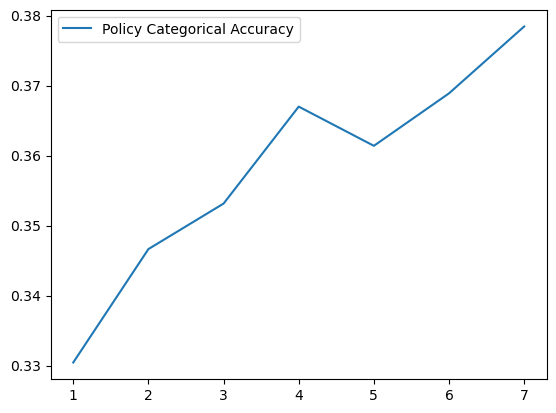

<Figure size 640x480 with 0 Axes>

In [29]:
epochs_mod20 = range(1, len(acc) + 1)

plt.plot(epochs_mod20, acc, label='Policy Categorical Accuracy')
plt.legend()

plt.figure()

plt.show()